# Multi-lable classificatin


In [1]:
%matplotlib inline
import math
import os
import data_util
#from data_util import DataPoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer # convert y to {0,1}^L
from sklearn.preprocessing import StandardScaler # normalize features 
from sklearn.feature_extraction import DictVectorizer # extract feature vector to x
from numpy.random import normal # generate transforming matrix
from sklearn.neighbors import KDTree #KDTree for fast kNN search
from sklearn.externals import joblib # store classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import average_precision_score
from joblib import Parallel, delayed # Multitread

In [2]:
!ls -R ../data

../data:
AmazonCat  Bibtex  Delicious  Eurlex  Mediamill  RCV1-x  Wiki10

../data/AmazonCat:
amazonCat_test.txt  amazonCat_train.txt

../data/Bibtex:
Bibtex_data.txt  bibtex_trSplit.txt  bibtex_tstSplit.txt

../data/Delicious:
Delicious_data.txt  delicious_trSplit.txt  delicious_tstSplit.txt

../data/Eurlex:
eurlex_test.txt  eurlex_train.txt

../data/Mediamill:
Mediamill_data.txt  mediamill_trSplit.txt  mediamill_tstSplit.txt

../data/RCV1-x:
rcv1x_test.txt	rcv1x_train.txt

../data/Wiki10:
wiki10_test.txt  wiki10_train.txt


In [3]:
!wc ../data/Eurlex/eurlex_train.txt

   43908  5311020 64283692 ../data/Mediamill/Mediamill_data.txt


In [85]:
data_dir = "../data"
model_dir = "../.model2"
train_filename = "/Eurlex/eurlex_train.txt"
test_filename = "/Eurlex/eurlex_test.txt"
#tr_split_file = "/Delicious/delicious_trSplit.txt"
#te_split_file = "/Delicious/delicious_tstSplit.txt"

path = os.path.dirname(train_filename)
model_path = model_dir + path

In [86]:
tr_data, num_point, num_feature, num_label = data_util.read_file(data_dir+train_filename)
print("num_point={}, num_label={}, num_feature={}".format(num_point, num_label, num_feature))

num_point=15539, num_label=3993, num_feature=5000


In [87]:
te_data, _, _, _ = data_util.read_file(data_dir+test_filename)

In [62]:
#tr_split = data_util.split_data(data=tr_data, split_file=data_dir+tr_split_file)
#te_split = data_util.split_data(data=tr_data, split_file=data_dir+te_split_file)

In [88]:
X_tr, Y_tr, X_te, Y_te = data_util.data_transform(tr_data, te_data, num_label)

## Explore Data Analysis

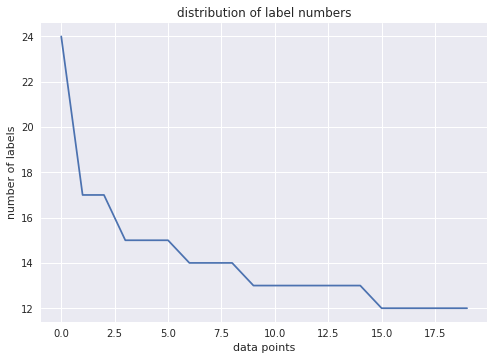

In [89]:
# number of labels for each data point
plt.plot(sorted([Y.sum() for Y in Y_tr], reverse=True)[:20])
plt.ylabel('number of labels')
plt.xlabel('data points')
plt.title('distribution of label numbers')

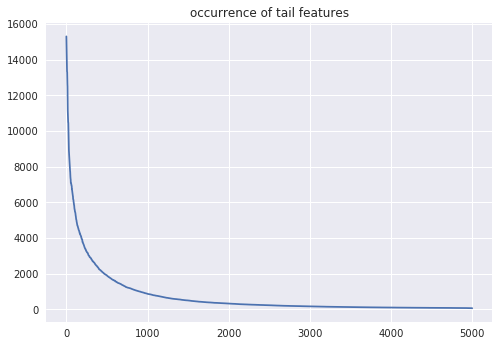

In [90]:
# usage of tail feature
plt.plot(sorted([np.count_nonzero(X_tr[:,i]) for i in range(X_tr.shape[1])], reverse=True))
plt.title('occurrence of tail features')

## Binary mapping + kNN
data set $(x,y)^d$, where $y_i=\{1, 0\}^L$

we want to map y into lower space by $$z = [M\cdot y]$$ where M is a multivariant i,i,d Gaussian matrix, and $[]$ is tkaing the sign.

Then we train binary classifiers on each bit of $z \in \{0, 1\}^{\hat L}$

For each test point, we predict its $\hat z$ and then use kNN to find the nearest k neighbors from $z=[My]$ which is all our lower degree space's mapping.

### Step 0: data preposseing
normalize features and select prominent features

In [91]:
# normalize features
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)
X_tr.shape

(15539, 5000)

### Step 1: map to $\hat L$ space and construct KD-tree

The apply $$\hat L = k \log L$$ where $k$ indicates the sparsity of each label vector $y_i = \{0,1\}^L$. By default we choose k to be the 99.9% maximum sparsity to avoid extreme cases.

The data in "Eurlex" contains $L = 5000$ labels, we are trying to map it into $\hat L = 200$ space.

In [92]:
k = sorted([Y.sum() for Y in Y_tr], reverse=True)[int(num_point*0.001)]
k

12

In [93]:
np.random.seed(0)
L_hat = k * math.log(Y_tr.shape[1], 2)
M = normal(size=(int(math.ceil(L_hat)), Y_tr.shape[1]))

In [97]:
Z_tr = M.dot(Y_tr.T).T # z = n*\hat L
Z_tr = np.apply_along_axis(lambda x: [0 if elem < 0 else 1 for elem in x], 0, Z_tr) #sign

In [98]:
Z_tr.shape

(15539, 144)

In [99]:
Y_tr.shape

(15539, 3993)

### Step 2: Train Model

#### 2.1 train binary classifiers on each bit

In [100]:
def train_bit(bit):
    print "Trianning model for the {}th bit\n... ... ... \n".format(bit)
    #clf = LogisticRegression(solver='sag')
    clf = LinearSVC(dual=False)
    clf.fit(y=Z_tr[:, bit], X=X_tr)
    joblib.dump(clf, os.path.join(model_path , 'label{}.pkl'.format(bit)))
    print "{}th bit's model successfully stored in {}/label{}.pkl\n".format(bit, model_path, bit)

```Python
for bit in range(Z_tr.shape[1]):
    print "Trianning model for the {}th bit\n... ... ... \n".format(bit)
    #clf = LogisticRegression(solver='sag')
    clf = LinearSVC(dual=False)
    clf.fit(y=Z_tr[:, bit], X=X_tr)
    joblib.dump(clf, os.path.join(model_path , 'label{}.pkl'.format(bit)))
    print "{}th bit's model successfully stored in {}/label{}.pkl\n".format(bit, model_path, bit)
```

In [ ]:
from joblib import Parallel, delayed # Multitread
Parallel(n_jobs=8)(delayed(train_bit)(i) for i in range(Z_tr.shape[1]))

Trianning model for the 0th bit
... ... ... 
Trianning model for the 5th bit
... ... ... 

Trianning model for the 3th bit
... ... ... 
Trianning model for the 4th bit
... ... ... 
Trianning model for the 1th bit
... ... ... 




Trianning model for the 2th bit
... ... ... 
Trianning model for the 6th bit
... ... ... 


Trianning model for the 7th bit
... ... ... 



In [72]:
# load the classifiers
clfs = []
for bit in range(Z_tr.shape[1]):
    clfs.append(joblib.load(os.path.join(model_path , 'label{}.pkl'.format(bit))))
len(clfs)

249

#### 2.2 Store the lower degree space info for kNN

We use opensource faiss library from FAIR to speedup the ANN(Approximate Nearest Neighbor) search

In [73]:
# can't install faiss, use kd_tree
kd_tree = KDTree(Z_tr) #kNN search
#dist, ind = kd_tree.query(Z_tr[0].reshape(1,-1), k=3) #usage

In [74]:
z_bits = []
for clf in clfs:
    z_bit = clf.predict(X_te)
    z_bits.append(z_bit)
Z_pred = np.column_stack(z_bits)

### Step 3 Prediction and Validation

In [75]:
# k=1 without voting
dist, ind = kd_tree.query(Z_pred, k=1) # can set k > 1 and vote
Y_pred = np.array([Y_tr[index[0]] for index in ind])

In [76]:
average_precision_score(y_true=Y_te, y_score=Y_pred, average='weighted')

0.32755961530919858

In [77]:
# k=5 with unweighted vote
dist, ind = kd_tree.query(Z_pred, k=20)


In [78]:
Y_pred = np.array([np.sum([Y_tr[index[i]] for i in range(len(index))], axis=0) for index in ind])

In [79]:
Y_pred

array([[0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 1]])

In [80]:
Y_te.shape

(3185, 983)

In [81]:
success = 0
for i in range(len(Y_pred)):
    index = np.argmax(Y_pred[i])
    if (Y_te[i, index] == 1):
        success += 1
preat1 = success / float(len(Y_pred))

In [82]:
preat1

0.5805337519623234